## Implementation of the MDP Order Dispatching Policy

In this notebook, we will design a toy example to simulate the ridesharing market and implement the MDP order dispatch policy. Although the algorithm is being motivated by applications in ridesharing platforms, similar ideas can be employed in other two sided marketplaces (e.g., food delivery companies) that involve sequential decision making over time and space as well.

First, let us import all the required modules. Here, the [`linear_sum_assignment`](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.linear_sum_assignment.html) function from `scipy.optimize` allows us to solve matching problem to assign drivers to call orders by maximizing the advantage function or minimizing the total distance. It is designed to solve the general linear sum assignment problem, e.g., 
\begin{eqnarray*}
    \sum_{i=1}^m \sum_{j=1}^n C_{i,j} a_{i,j},
\end{eqnarray*}
where $C_{i,j}$ is the cost of matching vertex $i$ of the first set (e.g., drivers) to vertex $j$ of the second set (e.g., orders) and $a_{i,j}$ equals 1 if $i$ and $j$ are matched and 0 otherwise. In addition, each row is assignment to at most one column, and each column to at most one row. If it has more rows than columns, then not every row needs to be assigned to a column, and vice versa.

In [1]:
from itertools import count
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.optimize import linear_sum_assignment 
from scipy.sparse.csgraph import min_weight_full_bipartite_matching

We next detail the experimental setup. Consider orders and drivers operating in a simple map of 9 × 9 spatial grids with 20 time steps. Meanwhile, orders can only be dispatched to drivers in Manhattan distance that are no greater than 2. An order will be canceled if not being assigned to any driver for a long time, with the cancelation time modeled as a truncated Gaussian in the range 0 to 5 with mean 2.5 and standard deviation 2 along the temporal axis.

The Manhattan distance is different from the Euclidean distance. See the following figure for details. Take from [here](https://www.researchgate.net/publication/343237167_Game_AI_techniques_applied_to_city_simulations)

<img src="./graph/manhattan_distance.png"  width="750"/>

In [2]:
NUMBER_OF_GRID_TILES_X = 9
NUMBER_OF_GRID_TILES_Y= 9
NUMBER_OF_TIME_STEPS = 20 

MAX_MANHATTAN_DISTANCE = 2

def manhattan_distance(p1,p2):
    return np.abs(p1[0]-p2[0]) + np.abs(p1[1]-p2[1])

We fix the number of orders to 100. The following code allows us to generate waiting time for all the orders. 

In [3]:
NUMBER_OF_ORDERS = 100

LOWER_BOUND_WAITING_TIME = 0
UPPER_BOUND_WAITING_TIME = 5
MEAN_WAITING_TIME = 2.5
STANDARD_DEVIATION_WAITING_TIME = 2

waiting_time_sampler = stats.truncnorm(
    (LOWER_BOUND_WAITING_TIME - MEAN_WAITING_TIME) / STANDARD_DEVIATION_WAITING_TIME, (UPPER_BOUND_WAITING_TIME - MEAN_WAITING_TIME) / STANDARD_DEVIATION_WAITING_TIME, loc=MEAN_WAITING_TIME, scale=STANDARD_DEVIATION_WAITING_TIME)

waiting_times = waiting_time_sampler.rvs(NUMBER_OF_ORDERS)

For data generation, we want to simulate realistic traffic patterns with a morning-peak and a night-peak, centralized on different locations of residential areas and working areas, respectively. Therefore, orders’ starting locations are sampled according to a two-component mixture of Gaussians and then truncated to integers in the spatiotemporal grids. Afterwards, orders' destinations and drivers' initial locations are randomly sampled from a discrete uniform distribution defined on the grids. Parameters of the mixture of Gaussians are as follows.

\begin{eqnarray*}
    \pi^{(1)}=1/3, &\,\,& \pi^{(2)}=2/3;\\
    \mu^{(1)}=[3,3,5], &\,\,& \mu^{(2)}=[6,6,15];\\
    \sigma^{(1)}=[2,2,3], &\,\,& \sigma^{(2)}=[2,2,3].
\end{eqnarray*}

The following code allows us to generate random samples from the two-component mixture distribution. 

In [4]:
PROBABILITY_FIRST_GAUSSIAN = 1./3
PROBABILITY_SECOND_GAUSSIAN = 2./3

MEAN_FIRST_GAUSSIAN = [3,3,5]
MEAN_SECOND_GAUSSIAN = [6,6,15]

STANDARD_DEVIATION_FIRST_GAUSSIAN = [2,2,3]
STANDARD_DEVIATION_SECOND_GAUSSIAN = [2,2,3]

LOWER_LIMITS_BY_DIMENSION = [0 for _ in range(3)]
UPPER_LIMITS_BY_DIMENSION = [NUMBER_OF_GRID_TILES_X - 1, NUMBER_OF_GRID_TILES_Y - 1, NUMBER_OF_TIME_STEPS - 1]

class TruncatedMultivariateNormalInteger():
    def __init__(self, normals):
        self._normals = []
        for [lower, upper, mean, standard_deviation] in normals:
            X = stats.truncnorm(
    (lower - mean) / standard_deviation, (upper - mean) / standard_deviation, loc=mean, scale=standard_deviation)
            self._normals.append(X)
    # size equals 3 (e.g., 3 independent truncated normals per mixture component) in our example
    def rvs(self, size):
        return np.array([[normal.rvs(size=1) for normal in self._normals] for _ in range(size)])

class MixtureModel():
    def __init__(self, submodels, weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.submodels = submodels
        self.weights = weights/np.sum(weights) 

    def rvs(self, size):
        rvs = [] 
        for i in range(size):
            random_model = np.random.choice(range(len(self.submodels)), p=self.weights)
            rvs.append(self.submodels[random_model].rvs(size=1))
        return np.round(np.squeeze(np.array(rvs))).astype(int)
    
first_truncated_multivariate_normal = TruncatedMultivariateNormalInteger([[LOWER_LIMITS_BY_DIMENSION[i], UPPER_LIMITS_BY_DIMENSION[i], MEAN_FIRST_GAUSSIAN[i], STANDARD_DEVIATION_FIRST_GAUSSIAN[i]] for i in range(3)])

second_truncated_multivariate_normal = TruncatedMultivariateNormalInteger([[LOWER_LIMITS_BY_DIMENSION[i], UPPER_LIMITS_BY_DIMENSION[i], MEAN_SECOND_GAUSSIAN[i], STANDARD_DEVIATION_SECOND_GAUSSIAN[i]] for i in range(3)])

mixture_gaussian_model = MixtureModel([first_truncated_multivariate_normal, second_truncated_multivariate_normal],[1./3,2./3])

The following code allows us to randomly generate the orders' destinations and drivers' initial locations from a discrete uniform distribution on the grids

In [5]:
def spawn_uniformly_x_y_location():
    return [np.random.choice(range(NUMBER_OF_GRID_TILES_X)), np.random.choice(range(NUMBER_OF_GRID_TILES_Y))]

We next calculate the reward associated with each trip. In this example, we use the completion rate (e.g., the percentage of orders being completed) as our objective. As such, for each order, the immediate reward is a binary variable, depending on whether it is being completed or not. 

We adopt a discounted setting. The discounted factor is fixed to 0.9. Recall from the lecture that the discounted reward is calculated in the following manner. 

<img src="./graph/discount_reward.png"  width="750"/>

The following function calculates the discounted reward based on the observed reward.

In [6]:
DISCOUNT_FACTOR = 0.9

def discounted_reward_mdp(gamma, T, R):
    total_gamma = 0
    discounted_gamma = 1
    for _ in range(T):
        total_gamma += discounted_gamma 
        discounted_gamma *= gamma
    return total_gamma * R / T

Next, we start to implement the MDP order dispatch policy. Recall from the lecture that the algorithm consists of two steps, corresponding to policy evaluation based on temporal difference learning and order dispatch by maximizing the total advantage function. Consider the policy evaluation step first. Let us review the policy evaluation algorithm. 

<img src="./graph/policy_evaluation.png"  width="750"/>
<img src="./graph/pe_pseudocode.png"  width="750"/>

The following function implements the policy evaluation algorithm. 

In [7]:
# Elements in state_transactions are quadruples state, action, reward, next_state
# action is a quadruple consisting of [idle = 0 / serve = 1, serving position [x,y], destination posotion [x,y]]
# V and N are 9*9*20 (3-d) matrices
# delta_t corresponds to the serving time, calculated based on the Manhanttan distance
time_ = 2 # The last component of state
def policy_evaluation(state_transactions, V, N, starting_index, method):
    if V is None:
        V = np.zeros(np.array(UPPER_LIMITS_BY_DIMENSION) - np.array(LOWER_LIMITS_BY_DIMENSION) + [1,1,1])
    if N is None:
        N = np.zeros(np.array(UPPER_LIMITS_BY_DIMENSION) - np.array(LOWER_LIMITS_BY_DIMENSION) + [1,1,1])
    for t in range(NUMBER_OF_TIME_STEPS, -1, -1):
        for state, action, reward, next_state in state_transactions[starting_index:]:
            if state[time_] == t:
                N[tuple(state)] += 1
                delta_t = 1
                if action[0] == 1:
                    delta_t += manhattan_distance(state[:2], action[1]) + manhattan_distance(action[1], action[2])    
                future_value = 0
                if next_state[time_] < NUMBER_OF_TIME_STEPS:
                    future_value = np.power(DISCOUNT_FACTOR, delta_t) * V[tuple(next_state)]
                if method == 'mdp':
                    modified_reward = discounted_reward_mdp(DISCOUNT_FACTOR, delta_t ,reward)
                elif method == 'myopic':
                    modified_reward = reward
                V[tuple(state)] += 1./(N[tuple(state)]) * (future_value + modified_reward - V[tuple(state)])
    return V, N

ratios_of_served_orders = []

Finally, let us review the order dispatch step. 

<img src="./graph/CD.png"  width="750"/>
<img src="./graph/MDP.png"  width="750"/>

The definition of the advantage function is given below.

<img src="./graph/ad_fun.png"  width="750"/>

The following code implements the entire algorithm when being applied to the toy example. In a first phase it creates a historical dataset that lasts for 450 days (450 episodes) by running the 'distance' method (e.g., the closest-driver policy). Then, with this historical data the value function $V$ gets computed, based on which a new matching algorithm is devised. Next, we generate another 50-day dataset (50 epsidodes) to evaluate the performance of different policies. 

In [8]:
BASE_REWARD_PER_TRIP = 1
REWARD_FOR_DISTANCE_PARAMETER = 0

def real_time_order_dispatch_algorithm():

    NUM_EPISODES = 500 
    BENCHMARK_RUNS = 50 
    NUM_INDEPENDENT_RUNS = NUM_EPISODES - BENCHMARK_RUNS 

    # Consider three settings where the number of drivers equals 25, 50 and 75, respectively. Recall that the total number of orders is given by 100.
    number_of_drivers_list = [25,50,75]
    # Consider three methods, distance (closest driver policy), myopic policy (gamma=0) and MDP policy
    method_list = ['distance', 'myopic', 'mdp']
    # Consider two measurements, the completion rate and the average distance between orders and drivers
    measurement_keypoints = ['ratio served', 'average distance to driver']

    stored_mdp_V_functions = [] 
    
    # Measures the performance for each algorithm
    benchmark_data = np.zeros((len(number_of_drivers_list), len(method_list), len(measurement_keypoints),BENCHMARK_RUNS))

    for number_of_drivers_ind, number_of_drivers in enumerate(number_of_drivers_list):
        for method_ind, method in enumerate(method_list):
            transition_data = []
            if method in ['mdp', 'myopic']:
                ## Initialize the value and the state counter
                V, N = policy_evaluation(transition_data, None, None, 0, method)
                starting_index = 0

            for episode in range(NUM_EPISODES): 
                
                order_driver_distances = []

                # Generate 450 episodes as historical data and then 50 episodes to evaluate difference policies
                if episode >= NUM_INDEPENDENT_RUNS and method in ['mdp', 'myopic']:
                    V, N = policy_evaluation(transition_data, V, N, starting_index, method)
                    starting_index = len(transition)

                destinations = []
                for _ in range(NUMBER_OF_ORDERS):
                    # destination is drawn uniformly randomly from the grid
                    destinations.append(spawn_uniformly_x_y_location())
                
                # in orders first entry is boolean corresponding to wether it is served.
                orders = list(map(list, zip([False] * NUMBER_OF_ORDERS, mixture_gaussian_model.rvs(NUMBER_OF_ORDERS), np.round(waiting_times).astype(int), destinations, range(NUMBER_OF_ORDERS))))
                drivers = []
                for i in range(number_of_drivers):
                    # first entry describes the first time the driver is available again
                    # driver's location is drawn uniformly randomly from the grid
                    drivers.append([0, spawn_uniformly_x_y_location(), i])
                    
                for t in range(NUMBER_OF_TIME_STEPS):
                    # obtain active orders
                    active_orders = [order for order in orders if (order[0] == False) and (order[1][2] <= t) and (order[1][2] + order[2] >= t)]
                    available_drivers = [driver for driver in drivers if driver[0] <= t]
                    # print(len(active_orders), len(available_drivers)) 
                    # print(drivers)

                    allowed_match = np.ones((len(active_orders), len(available_drivers)), dtype=bool)
                    for order_count, active_order in enumerate(active_orders):
                        for driver_count, available_driver in enumerate(available_drivers):
                            # only consider drivers whose manhattan distance is slower than 2
                            if manhattan_distance(available_driver[1], active_order[1][:2]) > MAX_MANHATTAN_DISTANCE:
                                allowed_match[order_count, driver_count] = False
                    # print(allowed_match)

                    # computation of advantage function
                    if method in ['mdp', 'myopic']:
                        #Could also initialize with - infinity.
                        advantage_function = np.zeros((len(active_orders), len(available_drivers))) 
                        for order_count, active_order in enumerate(active_orders):
                            for driver_count, available_driver in enumerate(available_drivers):
                                if(allowed_match[order_count, driver_count]):
                                    # the pickup time
                                    delta_t = 1 + manhattan_distance(available_driver[1], active_order[1][:2]) + manhattan_distance(active_order[1][:2], active_order[3])    
                                    reward = BASE_REWARD_PER_TRIP + REWARD_FOR_DISTANCE_PARAMETER  * manhattan_distance(active_order[1][:2], active_order[3])  
                                    #If the completion time is later than the last time step, we just stop set the future value to zero
                                    future_value = 0.
                                    if t + delta_t < NUMBER_OF_TIME_STEPS: 
                                        discount = DISCOUNT_FACTOR
                                        if method == 'myopic':
                                            discount = 0.
                                        future_value = np.power(discount, delta_t) * V[active_order[3][0],active_order[3][1], t + delta_t]
                                    current_value = V[available_driver[1][0], available_driver[1][1], t]
                                    modified_reward = reward
                                    if method == 'mdp':
                                        modified_reward = discounted_reward_mdp(DISCOUNT_FACTOR, delta_t, reward)
                                    advantage_function[order_count, driver_count] = future_value - current_value + modified_reward
                        
                        # plot_sample_histogram(np.array([active_order[1] for active_order in active_orders]), "Active Orders at time {}".format(t))
                        # plot_sample_histogram(np.array([available_driver[1] for available_driver in available_drivers]), "Available Drivers at time {}".format(t))
                        
                        # print(advantage_function)
                        # print(advantage_function.shape)
                        
                        # Matchs orders to drivers. Note the important subtelty that the function linear_sum_assignment returns a full matching. But we are happy with a partial matching already.

                    row_ind = [] 
                    col_ind = []

                    # The initial independent runs should use the 'distance' policy to find the matching.
                    # Later runs could either use 'mdp', 'myopic' or 'distance' policy
                    if episode >= NUM_INDEPENDENT_RUNS and method in ['mdp','myopic']:
                        penalized_advantage_matrix = advantage_function
                        for i in range(len(active_orders)):
                            for j in range(len(available_drivers)):
                                if not allowed_match[i,j]:
                                    penalized_advantage_matrix[i,j] = - 100 * NUMBER_OF_ORDERS
                        row_ind, col_ind = linear_sum_assignment(-penalized_advantage_matrix)

                    else:
                        #Use distance matrix to compute assignment
                        distance_matrix = -np.ones((len(active_orders), len(available_drivers))) * 100 * NUMBER_OF_ORDERS
                        for i in range(len(active_orders)):
                            for j in range(len(available_drivers)):
                                if allowed_match[i,j]:
                                    distance_matrix[i,j] = -manhattan_distance(available_drivers[j][1], active_orders[i][1][:2]) 
                        row_ind, col_ind = linear_sum_assignment(-distance_matrix) 

                    matched_order_ind = []
                    matched_driver_ind = []

                    for i in range(len(row_ind)):
                        if row_ind[i] < len(active_orders) and col_ind[i] < len(available_drivers) and allowed_match[row_ind[i],col_ind[i]]:
                            matched_order_ind.append(row_ind[i])
                            matched_driver_ind.append(col_ind[i])

                    # print(f"Matched orders in iteration {t}")
                    for i in range(len(matched_order_ind)):
                        if allowed_match[matched_order_ind[i]][matched_driver_ind[i]]:
                            matched_order = active_orders[matched_order_ind[i]]
                            matched_driver = available_drivers[matched_driver_ind[i]]
                            # if method == 'mdp':
                                # print(f'Order {matched_order[-1]} at {matched_order[1][:2]} is matched to driver {matched_driver[-1]} at {matched_driver[1]}')
                            matched_order[0] = True

                            order_driver_distance = manhattan_distance(matched_driver[1], matched_order[1][:2])

                            # continue to run the code only when the assertion is satisfied. Stop and return an error otherwise
                            assert(order_driver_distance <= 2)

                            order_driver_distances.append(order_driver_distance)

                            delta_t = 1 + manhattan_distance(matched_driver[1], matched_order[1][:2]) + manhattan_distance(matched_order[1][:2], matched_order[3])    
                            matched_driver[0] = t + delta_t 

                            #Append to transition data.
                            
                            reward = BASE_REWARD_PER_TRIP + REWARD_FOR_DISTANCE_PARAMETER  * manhattan_distance(matched_order[1][:2], matched_order[3])  
                            
                            transition = [[matched_driver[1][0], matched_driver[1][1], t], [1, matched_order[1][:2], matched_order[3]], reward, [matched_order[3][0], matched_order[3][1], t + delta_t]]
                            transition_data.append(transition.copy())

                    # Set transition data for unmatched drivers 
                    for i, unmatched_driver in enumerate(available_drivers):
                        if i not in matched_driver_ind:
                            transition = [[unmatched_driver[1][0], unmatched_driver[1][1], t],[0],0,[unmatched_driver[1][0], unmatched_driver[1][1], t + 1]]
                            transition_data.append(transition.copy())

                if episode >= NUM_INDEPENDENT_RUNS: 
                    number_of_served_orders = 0
                    for i in range(len(orders)):
                        number_of_served_orders += orders[i][0]
                        
                    # calculate the completion rate
                    ratio_served = float(number_of_served_orders)/ NUMBER_OF_ORDERS
                    benchmark_data[number_of_drivers_ind, method_ind, :,  episode - NUM_INDEPENDENT_RUNS] = [ratio_served, np.mean(np.array(order_driver_distances))]
                    if method == 'mdp' and episode == NUM_EPISODES - 1:
                        # Used for visualising value functions
                        stored_mdp_V_functions.append(V.copy()) 

    print(benchmark_data) 
    plot_benchmarks(benchmark_data, number_of_drivers_list, method_list, measurement_keypoints) 
    plot_value_functions(stored_mdp_V_functions)

Here are the plotting functions: 

In [11]:
def plot_benchmarks(benchmark_data, number_of_drivers_list, method_list, measurement_keypoints):
    
    fig, axes = plt.subplots(1, benchmark_data.shape[2]) 
    benchmark_mean = np.mean(benchmark_data, axis = 3)
    benchmark_std = np.std(benchmark_data, axis = 3)

    barWidth = 0.25

    barColors = ['tab:red', 'tab:green', 'tab:blue']

    for idx, ax in enumerate(axes):
        data_mean = benchmark_mean[:,:,idx] 
        data_std = benchmark_std[:,:,idx]
        
        # The x position of bars
        x_pos = []
        r1 = np.arange(len(number_of_drivers_list))
        for i in range(len(method_list)): 
            x_pos.append([x + i * barWidth for x in r1]) 

        for method_idx, method in enumerate(method_list):
            ax.bar(x_pos[method_idx], data_mean[:,method_idx], width = barWidth, color = barColors[method_idx], yerr=data_std[:,method_idx], capsize=7, label=method)
        # general layout
        ax.set_xticks([r + barWidth for r in range(len(number_of_drivers_list))])
        ax.set_xticklabels(number_of_drivers_list)
        ax.set_title(measurement_keypoints[idx]) 

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=len(method_list)) 
    #Show graphic
    plt.show() 
    
def plot_value_functions(value_functions):
    time_step = 3
    
    fig = plt.figure(figsize=(12, 8))

    for idx in range(len(value_functions)):
        ax = fig.add_subplot(1,len(value_functions),idx+1, projection='3d')
        plot_values = value_functions[idx][:,:,time_step]

        # print("Value function is ", plot_values)

        X = np.arange(NUMBER_OF_GRID_TILES_X)
        Y = np.arange(NUMBER_OF_GRID_TILES_Y)
        
        X, Y = np.meshgrid(X,Y)

        ax.plot_surface(X, Y, plot_values, cmap=plt.cm.coolwarm, linewidth=1, rstride=1, cstride=1)

        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Value")
    
    plt.suptitle("Values at time {}".format(time_step))
    plt.show()    

Let us run the algorithm. It takes more than 10 minutes to finish running the algorithm. 

[[[[0.51       0.52       0.49       0.38       0.42       0.41
    0.46       0.49       0.53       0.46       0.59       0.45
    0.41       0.46       0.46       0.47       0.58       0.45
    0.54       0.45       0.44       0.5        0.51       0.49
    0.44       0.45       0.43       0.51       0.51       0.49
    0.46       0.5        0.49       0.41       0.49       0.52
    0.52       0.44       0.48       0.49       0.52       0.51
    0.55       0.47       0.51       0.41       0.51       0.47
    0.54       0.47      ]
   [1.2745098  1.05769231 1.26530612 1.34210526 1.28571429 1.36585366
    1.30434783 1.02040816 1.20754717 1.17391304 1.27118644 1.28888889
    1.24390244 1.08695652 1.30434783 1.36170213 1.13793103 1.11111111
    1.18518519 1.04444444 1.22727273 1.18       1.09803922 1.34693878
    1.34090909 1.11111111 1.51162791 1.41176471 1.17647059 1.40816327
    1.17391304 1.2        1.24489796 1.07317073 1.30612245 1.15384615
    1.26923077 1.13636364 1.22916667 1.28

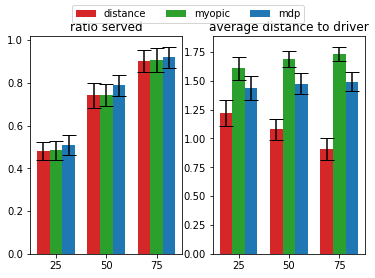

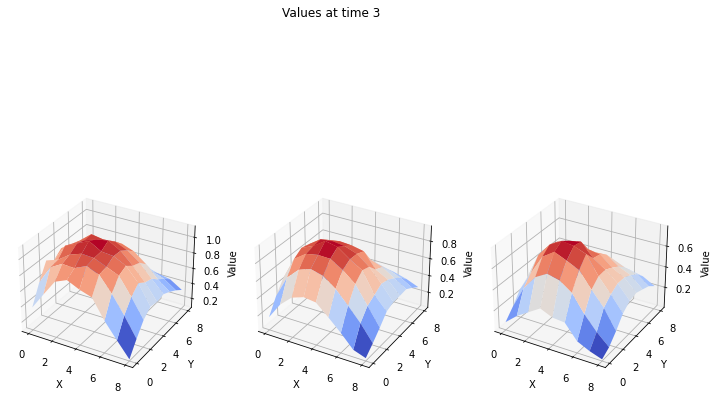

In [12]:
real_time_order_dispatch_algorithm()